In [1]:
import numpy as np 
from numpy import argmax
from numpy import array_equal
from numpy import array
import statistics

import tensorflow as tf
import itertools
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

from keras.metrics import categorical_crossentropy

from itertools import chain

tf.keras.backend.set_floatx('float64')


In [2]:
#Checking for tensorflow-GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


In [3]:
#Unzipping Attack and Validation folders

# Unzip Attack Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Attack_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Attack File')
    
# Unzip Validation Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Validation_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Validation File')
    
# Unzip Training Folder to retrive subfolfers
from zipfile import ZipFile
file_name = "Training_Data_Master.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Unizipped Training File')

# list holding normal training data
train_normal_data = [] 



from pathlib import Path 
# list that holds attack vectors
train_attack_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Attack_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_attack_data.append(string_split_data)
    

for i in range(len(train_attack_data)):
  for j in range(len(train_attack_data[i])):
    train_attack_data[i][j] = int(train_attack_data[i][j])

from pathlib import Path 
# list that holds validation vectors
train_validation_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Validation_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_validation_data.append(string_split_data)
    

# list that holds training vectors
train_normal_data = []

# Set file path ot the folder for iterations
input_dir = Path.cwd() / "Training_Data_Master"
# store all the files ending with .txt in a list called files
files = list (input_dir.rglob("*.txt*"))
# Iterate over all the txt files and append the attack in the list train_attack data
for FILE in files:
  with open (FILE, 'r') as f:
    stringData = (f.read())
    string_split_data = stringData.split(" ")
    del (string_split_data[-1])
    train_normal_data.append(string_split_data)
    

for i in range(len(train_normal_data)):
  for j in range(len(train_normal_data[i])):
    train_normal_data[i][j] = int(train_normal_data[i][j])
print("Normal Data     --->  train_normal_data")
print("Attack Data     --->  train_attack_data")
print("Validation Data --->  train_validation_data")


Unizipped Attack File
Unizipped Validation File
Unizipped Training File
Normal Data     --->  train_normal_data
Attack Data     --->  train_attack_data
Validation Data --->  train_validation_data


In [4]:
#Statistics of the data

#Shortest request
shortest_seq = 1000;
#Longest request
longest_seq = 0;
#Average Request size in dataset
avg_seq = 0

sum = 0;
for i in range(len(train_normal_data)):
    curr_sequence_length = len(train_normal_data[i])
    if curr_sequence_length < shortest_seq:
        shortest_seq = curr_sequence_length
    if curr_sequence_length > longest_seq:
        longest_seq = curr_sequence_length
    sum += curr_sequence_length
avg_seq = int(sum/len(train_normal_data))

print(f"Shortest Request Length is {shortest_seq}")
print(f"Longest Request Length is {longest_seq}")
print(f"Average Request Length is {avg_seq}")
    

Shortest Request Length is 79
Longest Request Length is 2948
Average Request Length is 369


In [5]:
len(train_validation_data)

4372

In [6]:
#Number of unique system calls in the normal list
unique_normal = []
# System calls that are present in the attack list but not in normal
attack_not_in_normal = []

#Appending unique system calls from the normal list
for i in range(len(train_normal_data)):
    for j in range(len(train_normal_data[i])):
        curr_sys_call = train_normal_data[i][j]
        if curr_sys_call in unique_normal:
            continue
        else:
            unique_normal.append(curr_sys_call)

#Appending unique system calls from the attack list that are not present in normal
for i in range(len(train_attack_data)):
    for j in range(len(train_attack_data[i])):
        curr_sys_call = train_attack_data[i][j]
        if curr_sys_call not in unique_normal:
            attack_not_in_normal.append(curr_sys_call)

In [7]:
# Unique system calls in normal list
len(unique_normal)

150

In [8]:
# Unique system calls in attack list not present in normal
attack_not_in_normal

[324, 324, 324, 324, 324, 324, 324, 173, 156]

In [9]:
freq_normal_dict = {}
#Appending unique system calls from the normal list
for i in range(len(train_normal_data)):
    for j in range(len(train_normal_data[i])):
        curr_sys_call = train_normal_data[i][j]
        if curr_sys_call in freq_normal_dict:
            freq_normal_dict[curr_sys_call] += 1 
        else:
            freq_normal_dict[curr_sys_call] = 0


In [10]:
 for i in sorted (freq_normal_dict.keys()):
     print(f"{i}:{freq_normal_dict[i]}", end = " ")

1:538 3:55663 4:31341 5:20502 6:22781 7:1554 8:1 9:40 10:246 11:700 12:70 13:893 15:22 19:832 20:79 21:3 26:3 27:189 30:15 33:7257 37:17 38:223 39:47 40:68 41:92 42:1226 43:1 45:5941 54:2768 57:40 60:104 63:941 64:72 65:9 66:44 75:0 77:1 78:10007 83:6 85:402 91:5599 93:19 94:32 96:11 97:29 99:6 102:8645 104:2 110:0 114:792 117:14 118:283 119:184 120:2214 122:298 125:4824 128:1 132:2 133:16 140:3759 141:268 142:1427 143:36 144:6 146:1602 148:32 155:39 157:30 158:97 159:88 160:82 162:259 163:24 168:10751 172:34 174:5911 175:5841 176:117 179:2 180:5960 183:22 184:1 185:0 191:198 192:13096 194:29 195:19413 196:3740 197:9975 198:0 199:344 200:111 201:377 202:123 203:8 204:8 205:6 206:5 207:29 208:11 209:20 211:15 212:8 213:19 214:6 219:281 220:1272 221:9783 224:0 226:9 228:8 229:15 230:7 231:8 233:0 234:1 240:13708 242:66 243:353 252:391 254:13 255:132 256:96 258:157 259:0 260:0 264:0 265:8222 266:44 268:123 269:11 270:2 272:4 289:6 292:43 293:8 295:8 298:3 300:35 301:194 307:46 308:314 309

In [11]:
freq_attack_dict = {}
#Appending unique system calls from the normal list
for i in range(len(train_attack_data)):
    for j in range(len(train_attack_data[i])):
        curr_sys_call = train_attack_data[i][j]
        if curr_sys_call in freq_attack_dict:
            freq_attack_dict[curr_sys_call] += 1 
        else:
            freq_attack_dict[curr_sys_call] = 0

In [12]:
 for i in sorted (freq_attack_dict.keys()) :
     print(f"{i}:{freq_attack_dict[i]}", end = " ")

3:45818 4:5551 5:6445 6:4190 7:293 10:224 11:66 12:48 13:6750 19:1693 20:1 27:749 33:1451 37:2 38:1 39:15 40:5 41:17 42:3 43:6070 45:346 54:4724 57:46 60:57 63:62 64:0 65:4 66:17 78:21124 85:723 91:2368 102:7780 104:2581 114:2045 117:5 118:4 119:518 120:160 122:111 125:1696 132:0 140:1132 141:67 142:11781 146:5505 156:0 158:111 160:0 162:6991 163:124 168:75174 172:9 173:0 174:1951 175:2694 183:25 191:61 192:3578 194:0 195:3321 196:794 197:1970 199:253 200:1 201:87 202:1 205:0 206:26 219:156 220:161 221:629 224:2 240:11315 242:15 243:54 256:573 258:67 265:61395 266:2 268:102 292:102 295:17 300:32 301:755 307:12 309:1973 311:70 324:6 331:12 340:429 

In [13]:
#Generating one hot vectors
dict = {}
vocab_size = 341

for x in range(vocab_size):
    arr=[]
    arr = [0 for i in range(vocab_size)] 
    arr[x] = 1
    dict[x] = arr

In [14]:
#Sequence size
n = 15
#N-Gram
m = 5

In [15]:
# This method receives a request array and returns one hot encoded version of that array
def generate_one_hot(request):
    temp = []
    for sys_call in request:
        temp.append(dict[int(sys_call)])
    return temp

# This method recevies a request array, start and  end of the request and populates x_train and y_train
# with returned one hot version from the generate_trainSet method
def split_request(source, target, request, start, end):
    while(len(request)-start >= n+m):
        source.append(generate_one_hot(request[start:end]))
        start += m
        end += m
        target.append(generate_one_hot(request[start:end]))
    

In [16]:
x_train = []
y_train = [] 

# Populating x_train and y_train with sources and targets
for i in range(len(train_normal_data)):
    split_request(x_train, y_train, train_normal_data[i],0,n)

In [17]:
print(len(x_train))
print(len(y_train))
print(len(train_normal_data))


58791
58791
833


In [18]:
# Converting x_train and y_train into np arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

In [19]:
#x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(y_train.shape)

(58791, 15, 341)
(58791, 15, 341)


In [20]:
# split test data into training and testing sets
x_train, x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.20,random_state=4)

In [21]:
n_timesteps = n
n_features = vocab_size
numberOfUnits = 200

input= Input(shape=(n_timesteps, n_features))

lstm1 = LSTM(numberOfUnits,return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm1(input) 
states = [state_h, state_c]

lstm1 = LSTM(numberOfUnits,return_sequences=True, return_state=True)
all_state_h, state_h, state_c = lstm1(input) 
states = [state_h, state_c]

lstm2 = LSTM(numberOfUnits,return_sequences=True)
all_state_h = lstm2(all_state_h,initial_state=states)

dense = (Dense(n_features, activation='softmax'))
output = dense(all_state_h)
model_LSTM_return_sequences_return_state = Model(input,output,
                                name='model_LSTM_all_state_h_return_state')
model_LSTM_return_sequences_return_state.compile(loss='categorical_crossentropy', 
                                                 optimizer='adam',
                                                 metrics=['accuracy'])
model_LSTM_return_sequences_return_state.summary()

Model: "model_LSTM_all_state_h_return_state"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15, 341)]    0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, 15, 200),    433600      ['input_1[0][0]']                
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                                  
 lstm_2 (LSTM)                  (None, 15, 200)      320800      ['lstm_1[0][0]',                 
                                                                

In [22]:
def train_test(model, X_train, y_train , 
               X_test, 	y_test, epochs=50, 
							        verbose=0, patience=5):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', 
	                   verbose=1, patience=patience)
	# train model
	print('training for ',epochs,
	      ' epochs begins with',
				' EarlyStopping(monitor= val_loss ',
				' patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,  verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

training for  50  epochs begins with  EarlyStopping(monitor= val_loss   patience= 5 )....
Epoch 21: early stopping
50  epoch training finished...
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

PREDICTION ACCURACY (%):
Train: 90.902, Test: 86.672


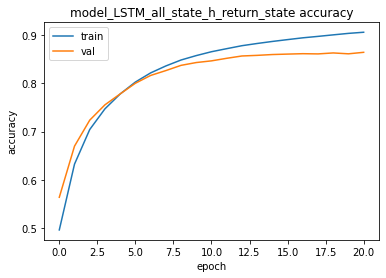

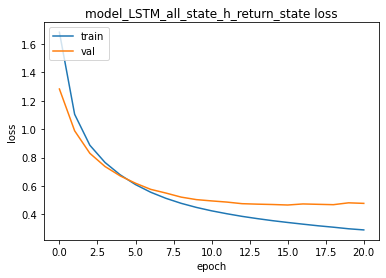

In [23]:
train_test(model_LSTM_return_sequences_return_state, x_train, y_train , x_test, y_test)

In [24]:
# import os.path
# if os.path.isfile('models/LSTM_HIDS.h5') is False:
#     model_LSTM_return_sequences_return_state.save('models/LSTM_HIDS.h5')

In [24]:
# Receives one hot represetation and returns index where value = 1
def one_hot_decode(arr):
    for index,num in enumerate(arr):
        if num == 1:
            return index
        
# Receives an array to append to and a 3D-array that is one hot encoded      
def decode(arr, three_d_array):
    for seq in three_d_array:
        temp = []
        for one_hot in seq:
            temp.append(one_hot_decode(one_hot))
        arr.append(temp)
    
        

In [25]:
# Decodes prediction done by LSTM and stores it in arr.
def prediction_decode(arr, prediction):
    for seq in prediction:
        predict_temp = []
        for one_hot in seq:
            predict_temp.append(argmax(one_hot))
        arr.append(predict_temp)
    
    

In [26]:
# perfect match
from nltk.translate.bleu_score import sentence_bleu
def calc_belu(target, prediction):
    reference = []
    candidate = []
    reference.append(target)
    candidate.extend(prediction)
    return sentence_bleu(reference, candidate, weights=(0, 1))

In [27]:
# VALIDATION

In [28]:
print(train_validation_data[2])

['195', '195', '195', '195', '5', '3', '168', '168', '168', '160', '168', '5', '4', '3', '45', '168', '168', '168', '168', '265', '168', '265', '265', '265', '265', '265', '3', '265', '265', '3', '265', '168', '146', '168', '146', '265', '265', '168', '168', '265', '265', '265', '265', '265', '168', '265', '265', '146', '168', '265', '168', '146', '3', '265', '168', '168', '265', '78', '3', '265', '168', '265', '265', '168', '3', '168', '197', '45', '45', '265', '78', '78', '78', '5', '3', '195', '6', '195', '3', '3', '78', '195', '3', '3', '195', '6', '195', '195', '195', '195', '195', '195', '195', '220', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '220', '195', '195', '195', '195', '195', '195', '195', '195', '220', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '195', '220', '195', '195', '195', '195', '195', '195', '195', '6', '195', '195', '195', '1

In [29]:
for i in range(len(train_validation_data)):
    for j in range(len(train_validation_data[i])):
        train_validation_data[i][j] = int(train_validation_data[i][j])

In [30]:
print(len(train_validation_data))

4372


In [86]:
def calc_request_belu_score(request,start,end):
    request_sources = []
    request_targets = []
    request_prediction = []
    request_scores= []
    
    min_hamming_list = []
    
    while(len(request)-start >= n+m):
        request_sources.append(generate_one_hot(request[start:end]))
        start += m
        end += m
        request_targets.append(request[start:end])
    
    i = 1
    while(i < len(request_sources)):
        prediction_decode( request_prediction, model_LSTM_return_sequences_return_state.predict(request_sources[i-1:i]))
        i += 1
    
    for i in range(len(request_prediction)):
        request_scores.append(calc_belu(request_targets[i],request_prediction[i]))
        min_hamming_list.append(calc_hamming_distance(request_targets[i],request_prediction[i]))
        
        
    
    return statistics.mean(min_hamming_list), statistics.mean(request_scores)

In [87]:
def calc_hamming_distance(target,prediction):
    hamming_dist = 0
    for i in range(len(target)):
        if target[i] != prediction[i]:
            hamming_dist += 1
    return hamming_dist

In [135]:
means = []
hamming_dist_normal = []

for i in range(len(train_validation_data)-2300-1000):
    print(f'{i+1}/{len(train_validation_data)-2300-1000}')
    print('-------------------------------------------------------------------')
    hamming_dist,mean_score = calc_request_belu_score(train_validation_data[i],0,n)
    hamming_dist_normal.append(hamming_dist)
    means.append(mean_score)
    
    

1/1072
-------------------------------------------------------------------
2/1072
-------------------------------------------------------------------
3/1072
-------------------------------------------------------------------
4/1072
-------------------------------------------------------------------
5/1072
-------------------------------------------------------------------
6/1072
-------------------------------------------------------------------
7/1072
-------------------------------------------------------------------
8/1072
-------------------------------------------------------------------
9/1072
-------------------------------------------------------------------
10/1072
-------------------------------------------------------------------
11/1072
-------------------------------------------------------------------
12/1072
-------------------------------------------------------------------
13/1072
-------------------------------------------------------------------
14/1072
-------------

109/1072
-------------------------------------------------------------------
110/1072
-------------------------------------------------------------------
111/1072
-------------------------------------------------------------------
112/1072
-------------------------------------------------------------------
113/1072
-------------------------------------------------------------------
114/1072
-------------------------------------------------------------------
115/1072
-------------------------------------------------------------------
116/1072
-------------------------------------------------------------------
117/1072
-------------------------------------------------------------------
118/1072
-------------------------------------------------------------------
119/1072
-------------------------------------------------------------------
120/1072
-------------------------------------------------------------------
121/1072
-------------------------------------------------------------------

216/1072
-------------------------------------------------------------------
217/1072
-------------------------------------------------------------------
218/1072
-------------------------------------------------------------------
219/1072
-------------------------------------------------------------------
220/1072
-------------------------------------------------------------------
221/1072
-------------------------------------------------------------------
222/1072
-------------------------------------------------------------------
223/1072
-------------------------------------------------------------------
224/1072
-------------------------------------------------------------------
225/1072
-------------------------------------------------------------------
226/1072
-------------------------------------------------------------------
227/1072
-------------------------------------------------------------------
228/1072
-------------------------------------------------------------------

323/1072
-------------------------------------------------------------------
324/1072
-------------------------------------------------------------------
325/1072
-------------------------------------------------------------------
326/1072
-------------------------------------------------------------------
327/1072
-------------------------------------------------------------------
328/1072
-------------------------------------------------------------------
329/1072
-------------------------------------------------------------------
330/1072
-------------------------------------------------------------------
331/1072
-------------------------------------------------------------------
332/1072
-------------------------------------------------------------------
333/1072
-------------------------------------------------------------------
334/1072
-------------------------------------------------------------------
335/1072
-------------------------------------------------------------------

430/1072
-------------------------------------------------------------------
431/1072
-------------------------------------------------------------------
432/1072
-------------------------------------------------------------------
433/1072
-------------------------------------------------------------------
434/1072
-------------------------------------------------------------------
435/1072
-------------------------------------------------------------------
436/1072
-------------------------------------------------------------------
437/1072
-------------------------------------------------------------------
438/1072
-------------------------------------------------------------------
439/1072
-------------------------------------------------------------------
440/1072
-------------------------------------------------------------------
441/1072
-------------------------------------------------------------------
442/1072
-------------------------------------------------------------------

537/1072
-------------------------------------------------------------------
538/1072
-------------------------------------------------------------------
539/1072
-------------------------------------------------------------------
540/1072
-------------------------------------------------------------------
541/1072
-------------------------------------------------------------------
542/1072
-------------------------------------------------------------------
543/1072
-------------------------------------------------------------------
544/1072
-------------------------------------------------------------------
545/1072
-------------------------------------------------------------------
546/1072
-------------------------------------------------------------------
547/1072
-------------------------------------------------------------------
548/1072
-------------------------------------------------------------------
549/1072
-------------------------------------------------------------------

644/1072
-------------------------------------------------------------------
645/1072
-------------------------------------------------------------------
646/1072
-------------------------------------------------------------------
647/1072
-------------------------------------------------------------------
648/1072
-------------------------------------------------------------------
649/1072
-------------------------------------------------------------------
650/1072
-------------------------------------------------------------------
651/1072
-------------------------------------------------------------------
652/1072
-------------------------------------------------------------------
653/1072
-------------------------------------------------------------------
654/1072
-------------------------------------------------------------------
655/1072
-------------------------------------------------------------------
656/1072
-------------------------------------------------------------------

KeyboardInterrupt: 

In [136]:
attack_means = []
hamming_dist_attack = []

for i in range((len(train_attack_data))):
    print(f'{i+1}/{len(train_attack_data)}')
    print('-------------------------------------------------------------------')
    hamming_dist,mean_score = calc_request_belu_score(train_attack_data[i],0,n)
    hamming_dist_attack.append(hamming_dist)
    attack_means.append(mean_score)
    
    
        
    

1/746
-------------------------------------------------------------------
2/746
-------------------------------------------------------------------
3/746
-------------------------------------------------------------------
4/746
-------------------------------------------------------------------
5/746
-------------------------------------------------------------------
6/746
-------------------------------------------------------------------
7/746
-------------------------------------------------------------------
8/746
-------------------------------------------------------------------
9/746
-------------------------------------------------------------------
10/746
-------------------------------------------------------------------
11/746
-------------------------------------------------------------------
12/746
-------------------------------------------------------------------
13/746
-------------------------------------------------------------------
14/746
---------------------------

111/746
-------------------------------------------------------------------
112/746
-------------------------------------------------------------------
113/746
-------------------------------------------------------------------
114/746
-------------------------------------------------------------------
115/746
-------------------------------------------------------------------
116/746
-------------------------------------------------------------------
117/746
-------------------------------------------------------------------
118/746
-------------------------------------------------------------------
119/746
-------------------------------------------------------------------
120/746
-------------------------------------------------------------------
121/746
-------------------------------------------------------------------
122/746
-------------------------------------------------------------------
123/746
-------------------------------------------------------------------
124/746
----

219/746
-------------------------------------------------------------------
220/746
-------------------------------------------------------------------
221/746
-------------------------------------------------------------------
222/746
-------------------------------------------------------------------
223/746
-------------------------------------------------------------------
224/746
-------------------------------------------------------------------
225/746
-------------------------------------------------------------------
226/746
-------------------------------------------------------------------
227/746
-------------------------------------------------------------------
228/746
-------------------------------------------------------------------
229/746
-------------------------------------------------------------------
230/746
-------------------------------------------------------------------
231/746
-------------------------------------------------------------------
232/746
----

327/746
-------------------------------------------------------------------
328/746
-------------------------------------------------------------------
329/746
-------------------------------------------------------------------
330/746
-------------------------------------------------------------------
331/746
-------------------------------------------------------------------
332/746
-------------------------------------------------------------------
333/746
-------------------------------------------------------------------
334/746
-------------------------------------------------------------------
335/746
-------------------------------------------------------------------
336/746
-------------------------------------------------------------------
337/746
-------------------------------------------------------------------
338/746
-------------------------------------------------------------------
339/746
-------------------------------------------------------------------
340/746
----

435/746
-------------------------------------------------------------------
436/746
-------------------------------------------------------------------
437/746
-------------------------------------------------------------------
438/746
-------------------------------------------------------------------
439/746
-------------------------------------------------------------------
440/746
-------------------------------------------------------------------
441/746
-------------------------------------------------------------------
442/746
-------------------------------------------------------------------
443/746
-------------------------------------------------------------------
444/746
-------------------------------------------------------------------
445/746
-------------------------------------------------------------------
446/746
-------------------------------------------------------------------
447/746
-------------------------------------------------------------------
448/746
----

543/746
-------------------------------------------------------------------
544/746
-------------------------------------------------------------------
545/746
-------------------------------------------------------------------
546/746
-------------------------------------------------------------------
547/746
-------------------------------------------------------------------
548/746
-------------------------------------------------------------------
549/746
-------------------------------------------------------------------
550/746
-------------------------------------------------------------------
551/746
-------------------------------------------------------------------
552/746
-------------------------------------------------------------------
553/746
-------------------------------------------------------------------
554/746
-------------------------------------------------------------------
555/746
-------------------------------------------------------------------
556/746
----

651/746
-------------------------------------------------------------------
652/746
-------------------------------------------------------------------
653/746
-------------------------------------------------------------------
654/746
-------------------------------------------------------------------
655/746
-------------------------------------------------------------------
656/746
-------------------------------------------------------------------
657/746
-------------------------------------------------------------------
658/746
-------------------------------------------------------------------
659/746
-------------------------------------------------------------------
660/746
-------------------------------------------------------------------
661/746
-------------------------------------------------------------------
662/746
-------------------------------------------------------------------
663/746
-------------------------------------------------------------------
664/746
----

In [137]:
print(statistics.mean(means))
print(statistics.mean(attack_means))
#16 difference

0.7746976106405471
0.6335612696255843


In [155]:
print(statistics.mean(hamming_dist_normal))
print(statistics.mean(hamming_dist_attack))


2.887105225215882
4.75523296480265


TypeError: '<' not supported between instances of 'list' and 'int'

In [185]:
belu_threshold = 0
hamming_threshold = 0
belu_threshold = statistics.mean(means) + statistics.stdev(means)
hamming_threshold = statistics.mean(hamming_dist_normal) - .88

In [186]:
print(belu_threshold)
print(hamming_threshold)

0.9239750929018965
2.007105225215882


In [187]:
# A false negative is saying something is false when it is actually true
false_negative = 0
for i in range(len(means)):
    if means[i] < belu_threshold and hamming_dist_normal[i] < hamming_threshold:
        false_negative += 1

        

In [188]:
# A false positive is when a we determine something is true when it is actually false
false_positive =  0
for i in range(len(attack_means)):
    if attack_means[i] > belu_threshold and hamming_dist_attack[i] > hamming_threshold:
        false_positive += 1

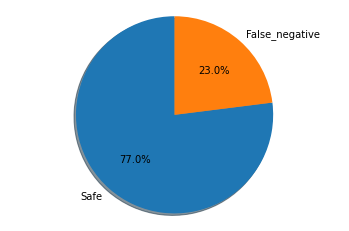

In [189]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Safe','False_negative'
sizes = [len(means)-false_negative,false_negative]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

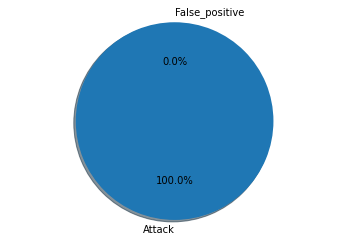

In [190]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Attack', 'False_positive'
sizes = [len(attack_means)-false_positive,false_positive]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [60]:
len(means)

102

#Binary Classification

In [73]:
# threshold = 0.834

threshold = .69

false_negative = []
false_positive = []
normal = []
anomaly = []

for avg in means:
    if avg > threshold:
        normal.append(avg)
    else:
        false_negative.append(avg)

for avg in attack_means:
    if avg > threshold:
        false_positive.append(avg)
    else:
        anomaly.append(avg)

    
    


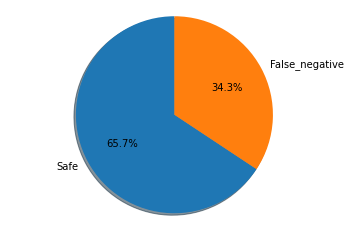

In [74]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Safe','False_negative'
sizes = [len(normal),len(false_negative)]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

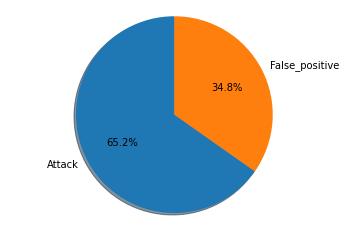

In [75]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Attack', 'False_positive'
sizes = [len(anomaly),len(false_positive)]
explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [57]:
#Binary End

In [58]:
threshold = .91

weak_t = 0.78

medium_t = 0.65

percentages = []

def calculate_threat(avg_list):

    weak_count = 0
    medium_count = 0
    strong_count = 0
    green_light = 0

    for i in range(len(avg_list)):
        if avg_list[i] >= threshold:
            green_light += 1
        elif avg_list[i] >= weak_t:
            weak_count += 1
        elif avg_list[i] >= medium_t:
            medium_count += 1
        else:
            strong_count += 1
    

    
    print(f'Green Light: {green_light/len(avg_list)}')        
    print(f'Weak threat: {weak_count/len(avg_list)}')
    print(f'Medium threat: {medium_count/len(avg_list)}')
    print(f'Strong threat: {strong_count/len(avg_list)}')
    
    percentages.append(green_light/len(avg_list)* 100)
    percentages.append(weak_count/len(avg_list) * 100)
    percentages.append(medium_count/len(avg_list) * 100)
    percentages.append(strong_count/len(avg_list) * 100)

In [ ]:
calculate_threat(means)

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Safe', 'Weak Threat', 'Medium Threat', 'Strong Threat'
sizes = [percentages[0],percentages[1],percentages[2],percentages[3]]
explode = (0.2, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
percentages = []
calculate_threat(attack_means)

In [ ]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Safe', 'Weak Threat', 'Medium Threat', 'Strong Threat'
sizes = [percentages[0],percentages[1],percentages[2],percentages[3]]
explode = (0.6, 0, 0, 0.3)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
plt.hist(means)
plt.hist(attack_means)